<a href="https://colab.research.google.com/github/Divyanshu-Singh-Chauhan/Image-Forgery-Detection/blob/DL/UNET_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


# DATASET PREPARATION 

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/CASIA2_COPY/CASIA2_ELA')
!unzip upd-tamp-ela1.zip -d /content/tamp/

Archive:  upd-tamp-ela1.zip
   creating: /content/tamp/tamp/
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20012_cha20012_02011.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20023_cha20023_02022.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20024_cha20024_02023.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20014_cha20014_02013.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_ind00005_ind00005_00882.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20036_cha20036_02487.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20047_cha20047_02046.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20043_cha20043_02431.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20046_cha20046_02045.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20038_cha20038_02037.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_ind00003_ind00003_01303.jpg  
  inflating: /content/tamp/tamp/Tp_S_NNN_S_N_cha20045_cha20045_02433.jpg  
  inflating: /content/tamp/tamp/Tp_S_NN

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/CASIA2_COPY/CASIA2_MASK')
!unzip upd-tamp-mask.zip -d /content/train1

Archive:  upd-tamp-mask.zip
   creating: /content/train1/tamp/
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_cha00087_ani00069_00407.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_ind00093_cha00023_00487.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_cha10176_cha10172_12285.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_ind00067_ind00066_00469.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_cha10134_pla00049_12203.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_nat00024_nat00027_11039.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_nat00041_art00020_11441.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_nat00040_nat00061_11434.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_nat00003_cha00096_00623.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_nat00090_ani00079_00682.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_nat00041_nat00061_11433.jpg  
  inflating: /content/train1/tamp/Tp_D_NNN_S_N_ind20047_ind20049_01788.jpg  
  inflating: 

In [ ]:
import os 
os.chdir('/content')
!mkdir train 

#### RENAMING THE UNZIPPED FOLDER #####
os.chdir('/content/train1')
os.rename('tamp','masks')
os.chdir('/content/tamp')
os.rename('tamp','images')


In [ ]:
img_height = 128
img_width = 128
nb_epochs = 40
batch_size = 25
train_path = '/content/train'

In [ ]:
#### Get and resize train images and masks ######
def get_data(path, train=True):
    ids = os.listdir(path + "/images")
    X = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (img_height, img_width, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
            mask = resize(mask, (img_height, img_width, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train_path, train=True)

Getting and resizing images ... 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2020)

# CALLBACKS 

In [ ]:
#### CALLBACKS ####

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
### MODELCHECKPOINT CALLBACK
save = ModelCheckpoint('/content/drive/My Drive/weights/unet_aug80.h5', verbose=1, save_best_only=True, save_weights_only=True)

### REDUCES LR WHEN METRTIC IS NOT IMPROVING
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta =1e-4, min_lr=0.00001, mode='min')

### LEARNING RATE SCHEDULER
def scheduler(epoch):

  if epoch < 5:
     return 0.001
  else:
     return float(0.001 * tf.math.exp(0.1 * (5 - epoch)))
lr_schedule = LearningRateScheduler(scheduler) 

### EARLY STOPPING
early_stopping = EarlyStopping(patience=10, verbose=1)


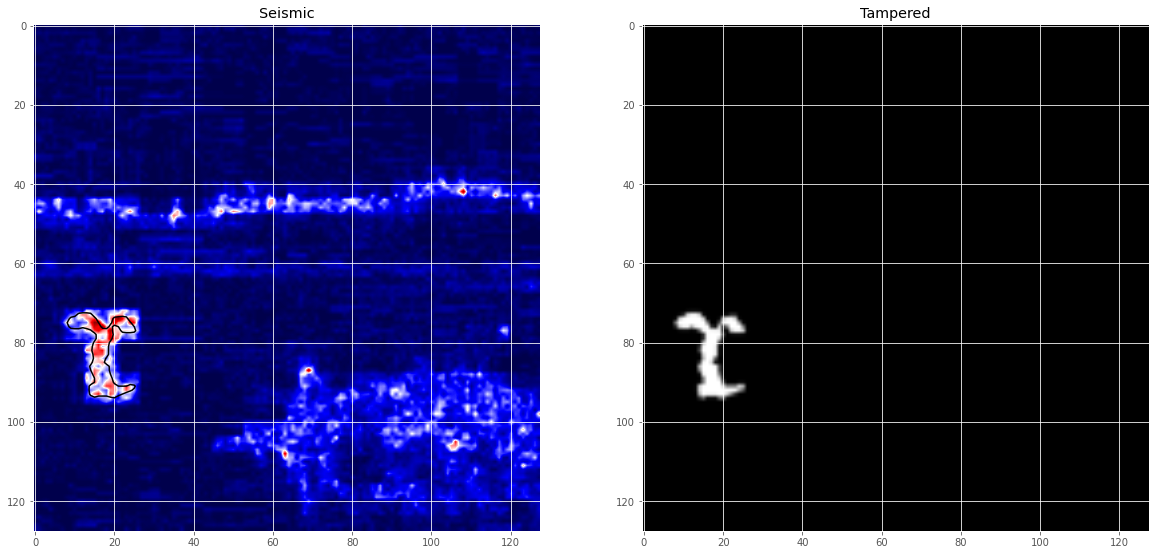

In [ ]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Tampered');

# MODEL AND COMPILATION


In [ ]:
def unet(input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    
    return model

In [ ]:
model = unet(input_size = (img_height, img_width, 1))
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [ ]:
model.load_weights('/content/drive/My Drive/weights/unet_aug80.h5')

In [ ]:
### AUGMENTATION ###

data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2020
bs = 25

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)


In [ ]:
### With Flips Augmentation ###
results = model.fit_generator(train_generator, steps_per_epoch=(len(X_train) // bs), epochs=nb_epochs, callbacks=[save,lr_schedule],
                              validation_data=(X_valid, y_valid))

### Without Augmentations ###
#results = model.fit(X_train, y_train, batch_size=batch_size, epochs= nb_epochs, callbacks=[early_stopping,save,lr_schedule, reduce_lr ],
#                    validation_data=(X_valid, y_valid))

Epoch 1/60
129/129 [==============================] - 136s 1s/step - loss: 0.0864 - accuracy: 0.9510 - val_loss: 0.1899 - val_accuracy: 0.9219

Epoch 00001: val_loss improved from inf to 0.18993, saving model to /content/drive/My Drive/weights/unet_aug80.h5
Epoch 2/60
129/129 [==============================] - 127s 981ms/step - loss: 0.0964 - accuracy: 0.9470 - val_loss: 0.1956 - val_accuracy: 0.9196

Epoch 00002: val_loss did not improve from 0.18993
Epoch 3/60
129/129 [==============================] - 121s 941ms/step - loss: 0.0940 - accuracy: 0.9479 - val_loss: 0.1928 - val_accuracy: 0.9229

Epoch 00003: val_loss did not improve from 0.18993
Epoch 4/60
129/129 [==============================] - 121s 941ms/step - loss: 0.0962 - accuracy: 0.9471 - val_loss: 0.1471 - val_accuracy: 0.9296

Epoch 00004: val_loss improved from 0.18993 to 0.14707, saving model to /content/drive/My Drive/weights/unet_aug80.h5
Epoch 5/60
129/129 [==============================] - 121s 942ms/step - loss: 0.0

# VISUALIZATION

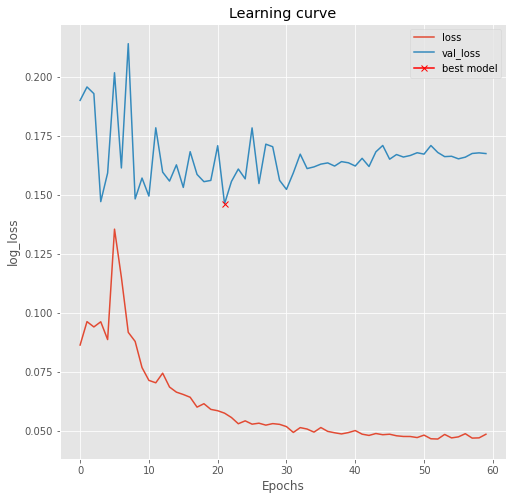

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
model.evaluate(X_valid, y_valid, verbose=1)
print("validation-loss, validation-acc")

572/572 [==============================] - 13s 22ms/step
validation-loss, validation-acc


# PREDICTION ON THE DATASET 

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

572/572 [==============================] - 6s 11ms/step


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original-image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('tampering-actual')
 
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('tampering Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('tampering Predicted binary');

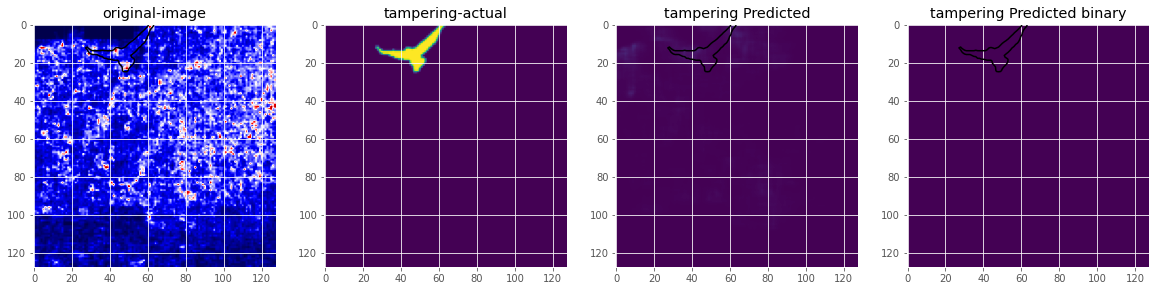

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=1)

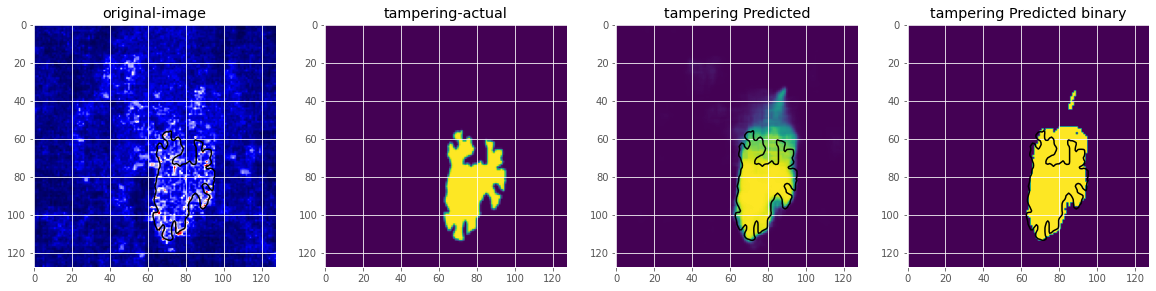

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1)

# PREDICTION ON A CUSTOM IMAGE

In [ ]:
import cv2
image_path = 'ela_spliced_image.png'
img = cv2.imread(image_path,0)
print(img.shape)
img = cv2.resize(img,(128,128))
print(img.shape)
img = np.expand_dims(img,axis = 0)
img = np.expand_dims(img,axis = -1)
print(img.shape)


os.chdir('/content')
preds_val = model.predict(img, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1)

(548, 796)
(128, 128)
(1, 128, 128, 1)
